LSTM is an RNN that can capture the pattern in sequential data. The benefit is that it can learn and remember for long sequences. In keras this is referred to as setting the stateful argument as true in the lstm layer 
Lstm includes three important gates: input gate, forget gate and the output gate. The interactive operation among these three gates makes LSTM have the sufficient ability to solve the problem of long-term dependencies
which general RNNs cannot learn. "The learning speed of the previous hidden layers is slower than the deeper
hidden layers. This phenomenon may even lead to a decrease of accuracy rate as hidden layers
increase [25]. However, the smart design of the memory cell in LSTM can effectively solve the problem
of gradient vanishing in backpropagation and can learn the input sequence with longer time steps.
Hence, LSTM is commonly used for solving applications related to time serial issues. "

- LSTMs are a type of recurrent network, and as such are designed to take sequence data as input, unlike other models where lag observations must be presented as input features.
- LSTMs directly support multiple parallel input sequences for multivariate inputs, unlike other models where multivariate inputs are presented in a flat structure.
- Like other neural networks, LSTMs are able to map input data directly to an output vector that may represent multiple output time steps.

- A popular approach has been to combine CNNs with LSTMs, where the CNN is as an encoder to learn features from sub-sequences of input data which are provided as time steps to an LSTM. This architecture is called a CNN-LSTM.
- A power variation on the CNN LSTM architecture is the ConvLSTM that uses the convolutional reading of input subsequences directly within an LSTM’s units. This approach has proven very effective for time series classification and can be adapted for use in multi-step time series forecasting.

In [23]:
import numpy as np
import pandas as pd
import pickle 
import sklearn 
import matplotlib.pyplot as plt 

In [24]:
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

In [25]:
with open('../data/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

In [26]:
with open('../data/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

In [27]:
#def evaluate_forecasts(actual, predicted):
train_data.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [28]:
test_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-07-02 12:00:00,0.056338,0.897059,0.704918,0.218182,0.333333,0.005349,0.0,0.0
2014-07-02 13:00:00,0.064386,0.897059,0.721311,0.218182,1.000000,0.000752,0.0,0.0
2014-07-02 14:00:00,0.066398,0.897059,0.721311,0.200000,1.000000,0.002273,0.0,0.0
2014-07-02 15:00:00,0.072435,0.897059,0.737705,0.200000,1.000000,0.003794,0.0,0.0
2014-07-02 16:00:00,0.078471,0.897059,0.737705,0.200000,1.000000,0.005315,0.0,0.0


## Moving Window NOT CV

The LSTM takes sequences of inputs. The pollution values can either be included (as lagged values) in the input or left out. 

In [29]:
def generate_sequence(df,N, window_size):
    '''Model expects the target labels to have two 
        dimensions with shape (batch_size,output_size). 
        - batch_size is the number of samples in each sequence
        - output_size is the number of target values per sample'''
        
    #We generate sequences of size 24
    X_sequences = [df.iloc[i:i+window_size].values for i in range(N - window_size)]
    #And for each sequence evaluate agains the pollution value following each sequence
    Y_values = [df.iloc[i+window_size]['pollution'] for i in range(N - window_size)]


    return np.array(X_sequences).astype('float64'), np.array(Y_values).astype('float64').reshape(-1,1)



Limit of sequence size is related to vanishing gradient problem. This can limit how well an LSTM can learn dependencies far back in the sequence, especially if the model isn’t deep enough to capture long-term patterns.

In [30]:
window_size = 10
N= len(train_data)
X_train, y_train = generate_sequence(train_data,N, window_size)
print(X_train.shape, y_train.shape)

M=len(test_data)
X_test, y_test = generate_sequence(test_data,M,window_size)
print(X_test.shape,y_test.shape)




(39410, 10, 8) (39410, 1)
(4370, 10, 8) (4370, 1)


Note: we reshape input to be 3D [samples, timesteps, features]

In [31]:
X_train.shape[1]

10

In [32]:
X_train.dtype

dtype('float64')

In [33]:
X_train.shape[2]

8

In [34]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D


In [36]:
np.random.seed(7)

history.predict(X_test): This generates predictions for X_test, resulting in a 2D array with shape (n, 1), where n is the number of test samples.
.flatten(): Converts this (n, 1) array to a 1D array with shape (n,), making it easier to work with 

# Standard LSTM

The model mininmizes mse and the mse loss is used for backpropoagtion to update the model's weights. RMSE is the evaluation metric.

In [37]:

STD_LSTM = Sequential()
STD_LSTM.add(Input(shape =(n_steps, n_features)))
STD_LSTM.add(LSTM(50))
STD_LSTM.add(Dense(1))
STD_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])


STD_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:


with tf.device('/CPU:0'):
    STD_LSTM.fit(X_train,y_train, epochs= 20,  validation_split=0.1, batch_size=64,shuffle=False)

train_loss, train_rmse =  STD_LSTM.evaluate(X_train,y_train, verbose=0)
print(train_rmse)
test_loss,test_rmse = STD_LSTM.evaluate( X_test,y_test,verbose=0)
print(test_rmse)



Epoch 1/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0038 - root_mean_squared_error: 0.0605 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.7528e-04 - root_mean_squared_error: 0.0310 - val_loss: 9.9333e-04 - val_root_mean_squared_error: 0.0315
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.6871e-04 - root_mean_squared_error: 0.0309 - val_loss: 9.9418e-04 - val_root_mean_squared_error: 0.0315
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━

In [39]:
train_loss, train_rmse =  STD_LSTM.evaluate(X_train,y_train, verbose=0)
print(train_rmse)
test_loss,test_rmse = STD_LSTM.evaluate( X_test,y_test,verbose=0)
print(test_rmse)

0.0324682742357254
0.029819630086421967


## Stacked LSTM

Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

After trialling different types of LSTM models with different activation functions and parameters, we decided the Stacked LSTM with tanh function was best in terms of performance and retaining a strong accuracy.

In [40]:
tf.random.set_seed(7)
STCK_LSTM = Sequential()
STCK_LSTM.add(Input(shape =(n_steps, n_features)))
STCK_LSTM.add(LSTM(32,return_sequences=True))
STCK_LSTM.add(Dropout(0.1)) #Prevent overfitting
STCK_LSTM.add(LSTM(16, return_sequences=False))
STCK_LSTM.add(Dense(n_outputs, activation ='linear')) 

STCK_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

# Save the initial weights of the model right after it is defined and compiled
initial_weights = STCK_LSTM.get_weights()

STCK_LSTM.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 32)         │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
with tf.device('/CPU:0'):
    
    history = STCK_LSTM.fit(X_train, y_train, epochs=150, validation_split=0.1,  callbacks=[early_stopping], batch_size=64,shuffle=False)

Epoch 1/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0048 - root_mean_squared_error: 0.0687 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 2/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 3/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 4/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 5/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 6/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 7/150
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 8m

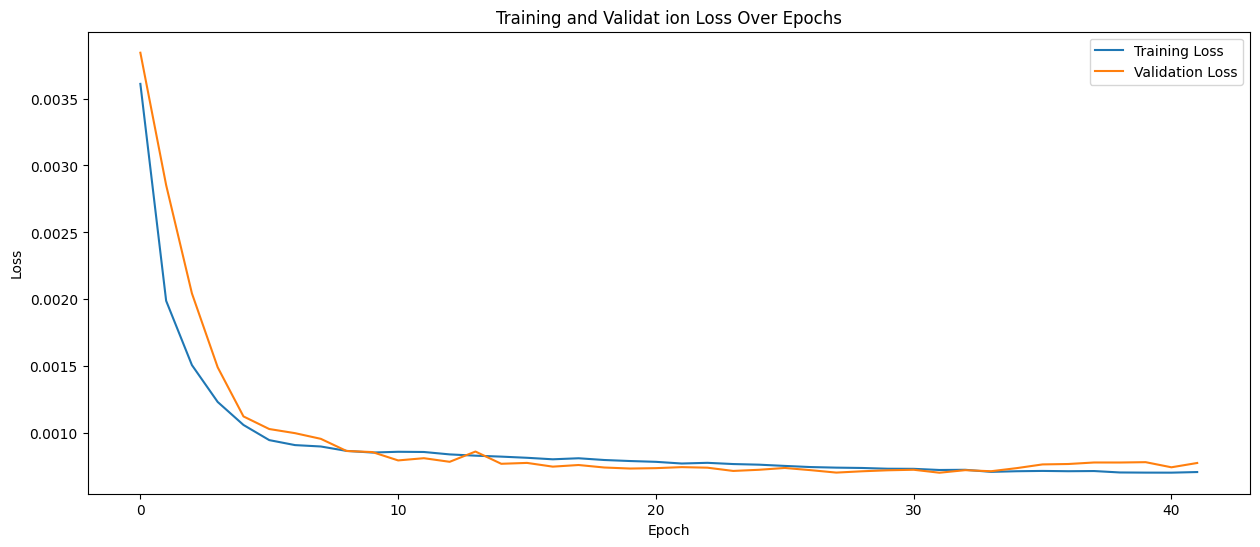

In [43]:
#Plot training and validation mse loss over epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')      
plt.plot(history.history['val_loss'], label='Validation Loss')  

plt.xlabel('Epoch')   
plt.ylabel('Loss')      
plt.legend()
plt.title('Training and Validat ion Loss Over Epochs')
plt.show()

The validation loss is only slightly higher than the training loss, indicating that the model is not overfitting.

## Model epoch and rmse performance 

In [44]:
#Reset weights to initial weights before starting new training 
STCK_LSTM.set_weights(initial_weights)

epochs=[]
train_rmse=[]
test_rmse=[]
delta_epochs=5
eon=0 
for i in range(0,10) : 
        print("epoch : " + str(eon))
        STCK_LSTM.fit(X_train, y_train, epochs=delta_epochs, batch_size=64,validation_split=0.1)
        train_scores = STCK_LSTM.evaluate(X_train, y_train)   
        tests_scores = STCK_LSTM.evaluate(X_test, y_test)
        eon+=delta_epochs
        epochs.append(eon)
        train_rmse.append(train_scores[1]) #RMSE
        test_rmse.append(tests_scores[1])

epoch : 0
Epoch 1/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0027 - root_mean_squared_error: 0.0510 - val_loss: 8.1723e-04 - val_root_mean_squared_error: 0.0286
Epoch 2/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 6.6207e-04 - val_root_mean_squared_error: 0.0257
Epoch 3/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 9.0505e-04 - root_mean_squared_error: 0.0301 - val_loss: 6.2490e-04 - val_root_mean_squared_error: 0.0250
Epoch 4/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 8.5289e-04 - root_mean_squared_error: 0.0292 - val_loss: 6.3402e-04 - val_root_mean_squared_error: 0.0252
Epoch 5/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 8.4793e-04 - root_mean_squared_error: 0.0291 - val_loss: 6.2729e-04 - val_root_mean_squared_error: 0.0250
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.0130e-04 - root_mean_squared_error: 0.0298
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1045e-04 - root_mean_

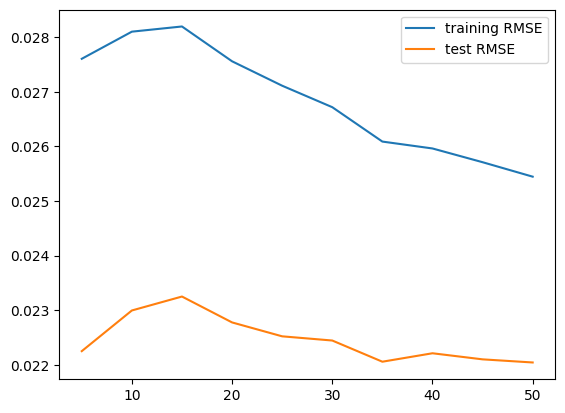

In [45]:
results=[epochs,
        train_rmse,
        test_rmse]
plt.plot(epochs,train_rmse,label='training RMSE')
plt.plot(epochs,test_rmse,label='test RMSE')
plt.legend()
plt.show()

In [46]:
print("Training target mean/std:", y_train.mean(), y_train.std())
print("Test target mean/std:", y_test.mean(), y_test.std())

Training target mean/std: 0.09503118686746208 0.09315282513845813
Test target mean/std: 0.09045554793290636 0.08972006961313139


In [47]:
train_metrics = STCK_LSTM.evaluate(X_train,y_train)
print(f"Train RMSE: {train_metrics[1]:.5f}")

 
test_metrics = STCK_LSTM.evaluate(X_test,y_test)
print(f"Test RMSE: {test_metrics[1]:.5f}")



1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.0631e-04 - root_mean_squared_error: 0.0265
Train RMSE: 0.02545
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9585e-04 - root_mean_squared_error: 0.0170
Test RMSE: 0.02204


In [48]:
train_preds = STCK_LSTM.predict(X_train)
test_preds = STCK_LSTM.predict(X_test)

train_residuals = y_train.flatten() - train_preds.flatten()
test_residuals = y_test.flatten() - test_preds.flatten()

print("Training Residuals Mean/STD:", train_residuals.mean(), train_residuals.std())
print("Test Residuals Mean/STD:", test_residuals.mean(), test_residuals.std())

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Residuals Mean/STD: 0.004058771678221991 0.025119443439917417
Test Residuals Mean/STD: 0.003468136330427274 0.021768594001818835


In [49]:
import numpy as np

# Parameters
section_length = 168  # Length of each time chunk to remove
n_sections =  50      # Number of chunks to remove

# Total number of sequences
total_sequences = len(X_train)

# Randomly select starting indices for the time chunks
np.random.seed(42)  # For reproducibility
start_indices = np.random.choice(
    range(total_sequences - section_length), size=n_sections, replace=False
)

# Collect indices to remove
excluded_indices = []
for start_idx in start_indices:
    excluded_indices.extend(range(start_idx, start_idx + section_length))

# Convert to NumPy arrays for easier manipulation
excluded_indices = np.array(excluded_indices)

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

# Create new training set by excluding the selected time chunks
X_train_reduced = np.delete(X_train_copy, excluded_indices, axis=0)
y_train_reduced = np.delete(y_train_copy, excluded_indices, axis=0)

# Print the shapes of the reduced dataset
print(f"Reduced training set shape: {X_train_reduced.shape}, {y_train_reduced.shape}")


Reduced training set shape: (31857, 10, 8), (31857, 1)


In [50]:
# Reset weights to initial weights before starting new training 
STCK_LSTM.set_weights(initial_weights)

epochs=[]
train_rmse=[]
test_rmse=[]
delta_epochs=5
eon=0 
for i in range(0,10) : 
        print("epoch : " + str(eon))
        STCK_LSTM.fit(X_train_reduced, y_train_reduced, epochs=delta_epochs, batch_size=64,validation_split=0.1)
        train_scores = STCK_LSTM.evaluate(X_train_reduced, y_train_reduced)   
        tests_scores = STCK_LSTM.evaluate(X_test, y_test)
        eon+=delta_epochs
        epochs.append(eon)
        train_rmse.append(train_scores[1]) #RMSE
        test_rmse.append(tests_scores[1])

epoch : 0
Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0033 - root_mean_squared_error: 0.0563 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 8.2931e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.5081e-04 - root_mean_squared_error: 0.0308 - val_loss: 7.6151e-04 - val_root_mean_squared_error: 0.0276
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 8.4773e-04 - root_mean_squared_error: 0.0291 - val_loss: 7.2563e-04 - val_root_mean_squared_error: 0.0269
Epoch 5/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 7.9826e-04 - root_mean_squared_error: 0.0283 - val_loss: 7.0572e-04 - val_root_mean_squared_error: 0.0266
996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.0034e-04 - root_mean_squared_error: 0.0282
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5197e-04 - root_mean_square

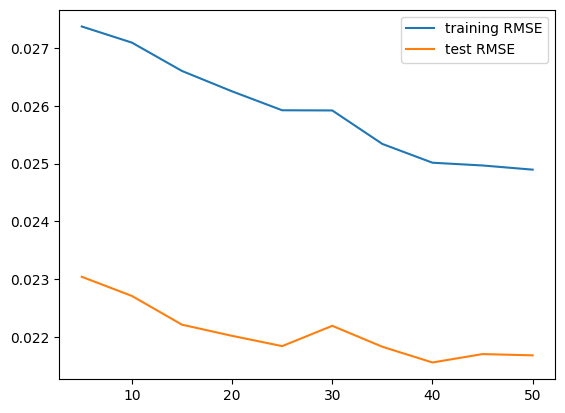

In [51]:
results=[epochs,
        train_rmse,
        test_rmse]
plt.plot(epochs,train_rmse,label='training RMSE')
plt.plot(epochs,test_rmse,label='test RMSE')
plt.legend()
plt.show()

In [52]:
results

[[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
 [0.027373047545552254,
  0.02709423005580902,
  0.026603572070598602,
  0.026250815019011497,
  0.025923531502485275,
  0.025920450687408447,
  0.02534095011651516,
  0.025016291067004204,
  0.02496856264770031,
  0.024896347895264626],
 [0.023042868822813034,
  0.022712143138051033,
  0.022214606404304504,
  0.022021528333425522,
  0.02184371091425419,
  0.02219492942094803,
  0.021832507103681564,
  0.02156076394021511,
  0.02170599065721035,
  0.02168412134051323]]

# NEED TO EVALUATE MODEL EACH TIME BEFORE SEEING HOW IT PERFORMS ON TEST 

From early stopping we have determined a good epoch value is less than 20 so let's see have a closer look on how accuracy is affected. 

The model is trained incrementally, but it retains the weights from previous iterations. This means that even though scaledtormodel.fit runs for only 5 epochs in each loop, the total effective training time for the model is the cumulative epoch count (eon).


## Evaluation: 
By this we see the optimal epoch value is between 15 and 20 and we continue with an epoch value of 17

- Try without final dense(activation='relu') layer 
- try early stopping 
- try different batch size but might cause overfitting 
- first make some nice graphs 
- then try different techniques entirely 


## DO A BATCH SIZE TEST ERROR PLOT TO DECIDCDE ON A BATCH SIZE 

In [53]:
X_train.shape

(39410, 10, 8)

[samples, timesteps, features]

In [54]:
with tf.device('/CPU:0'):
    # Reset weights to initial weights before starting new training loops
    STCK_LSTM.set_weights(initial_weights)
    STCK_LSTM.fit(X_train, y_train, epochs=30, validation_split=0.1, batch_size=32,shuffle=False)

Epoch 1/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0044 - root_mean_squared_error: 0.0639 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 2/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 3/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 4/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0322 - val_loss: 8.8629e-04 - val_root_mean_squared_error: 0.0298
Epoch 5/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 7.5367e-04 - val_root_mean_squared_error: 0.0275
Epoch 6/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0314 - val_loss: 8.4940e-04 - val_root_mean_squared_error: 0.0291
Epoch 7/30
1109/1109 ━━━━━━━

In [55]:
train_metrics = STCK_LSTM.evaluate(X_train,y_train)
print(f"Train RMSE: {train_metrics[1]:.5f}")


test_metrics = STCK_LSTM.evaluate(X_test,y_test)
print(f"Test RMSE: {test_metrics[1]:.5f}")

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.9896e-04 - root_mean_squared_error: 0.0315
Train RMSE: 0.03089
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0921e-04 - root_mean_squared_error: 0.0284
Test RMSE: 0.02933


In [56]:
test_predictions = STCK_LSTM.predict(X_test).flatten()
train_predictions = STCK_LSTM.predict(X_train).flatten()
train_actual = y_train.flatten()
actual_predictions = y_test.flatten()
test_predictions.shape, actual_predictions.shape

test_results = pd.DataFrame(data={
        'Model Predictions': test_predictions,
        'Actual':actual_predictions})
test_results.head()

train_results = pd.DataFrame(data = {
        'Model Predictions': train_predictions,
        'Actual':train_actual
})

train_results.head()

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,Model Predictions,Actual
0,0.140702,0.140845
1,0.149467,0.152918
2,0.161429,0.148893
3,0.153671,0.164990
4,0.176665,0.158954


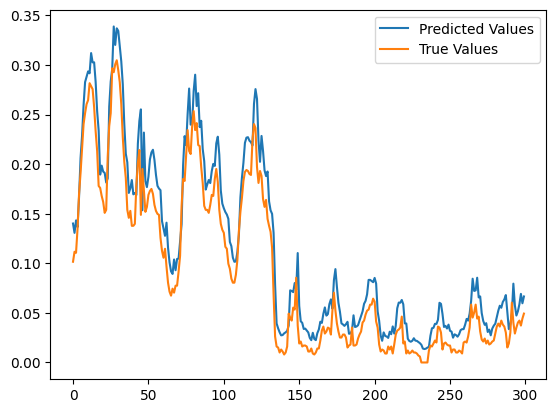

In [57]:
plt.plot(test_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

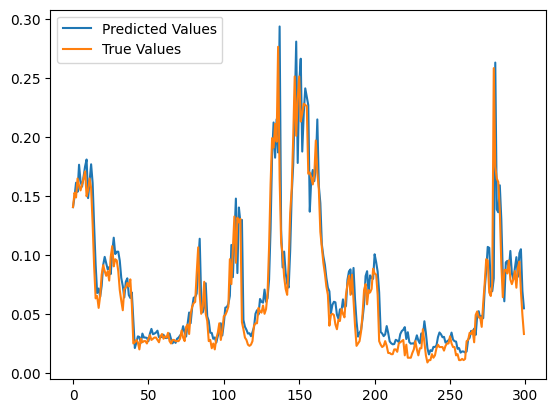

In [58]:
plt.plot(train_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(train_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

In [59]:
test_predictions = STCK_LSTM.predict(X_test)

X_test_rescaled=X_test[:, -1, :].copy()

# Invert scaling for the forecast
inv_test_predictions = concatenate((test_predictions, X_test_rescaled[:, 1:]), axis=1)
inv_test_predictions = scaler.inverse_transform(inv_test_predictions)
inv_test_predictions = inv_test_predictions[:, 0]  # Extract the pollution column

y_test = y_test.reshape((len(y_test),1))
inv_actual_predictions = concatenate((y_test, X_test_rescaled[:, 1:]), axis=1)
inv_actual_predictions = scaler.inverse_transform(inv_actual_predictions)
inv_actual_predictions = inv_actual_predictions[:,0]


test_results = pd.DataFrame(data={
        'Model Predictions': inv_test_predictions,
        'Actual':inv_actual_predictions})
  

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actual_predictions, inv_test_predictions))
print('Test RMSE: %.3f' % rmse)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test RMSE: 29.150


In [60]:
test_results

,Model Predictions,Actual
0,139.314843,101.0
1,129.942290,111.0
2,142.493771,110.0
3,135.765872,134.0
4,165.969557,169.0
...,...,...
4365,20.232841,8.0
4366,16.895498,10.0
4367,18.523050,10.0
4368,17.863005,8.0


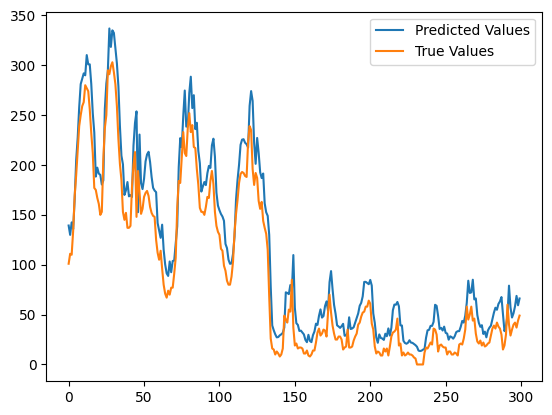

In [61]:
plt.plot(test_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

This seems to be best model, takes least time and similar accuracy 

Results seem to get progresively worse

ARIMA would have exponential forgetting 

## Multivariate Multi-Step LSTM

## GPU Performance

Using Apple's Metal API with Keras (TensorFlow)

In [62]:
!pip install tensorflow-macos
!pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Preprocess Data for GPU Usage 
The GPU version of tensorflow works with 32 bit floats which is important because some records might now return NAN on a GPU.

In [64]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('float64'))

In [65]:
import numpy as np

def preprocess_sequences(X, y):
    #Convert to float32 for GPU compatibility
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    #Handle NAN and infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    y = np.nan_to_num(y, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

    #Cap extreme values to prevent instability
    X = np.clip(X, -10, 10)  # Example range, adjust based on your data distribution
    y = np.clip(y, -10, 10)

    return X, y


X_train, y_train  =  preprocess_sequences(X_train, y_train)
X_test,y_test = preprocess_sequences(X_test, y_test)

In [66]:
X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'))

## Compare CPU and GPU Performance on Batch Size

In [67]:
import time

In [68]:
batch_sizes = [16, 32, 64, 128, 256]  # Different batch sizes to test
results = {"batch_size": [], "cpu_rmse":[], "cpu_time": [],"gpu_rmse":[], "gpu_time": []}

In [69]:
for batch_size in batch_sizes:
    # CPU
    with tf.device('/CPU:0'):
        # Reset weights to initial weights before starting new training loops
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=batch_size, shuffle=False)
        cpu_time = time.time() - start_time
        CPU_scores = STCK_LSTM.evaluate(X_test, y_test)

    # GPU
    with tf.device('/GPU:0'):
        # Reset weights to initial weights before starting new training loops
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=batch_size, shuffle=False)        
        gpu_time = time.time() - start_time
        GPU_scores = STCK_LSTM.evaluate(X_test, y_test)


    # Record results
    results["batch_size"].append(batch_size)
    results["cpu_rmse"].append(CPU_scores[1])
    results["cpu_time"].append(cpu_time)
    results["gpu_rmse"].append(GPU_scores[1])
    results["gpu_time"].append(gpu_time)

Epoch 1/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0041 - root_mean_squared_error: 0.0623 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 2/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 3/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 4/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0322 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 5/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 6/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 9.8838e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 7/20
2217/2217 ━━━━━━━━━

## Batch Size vs Training Time

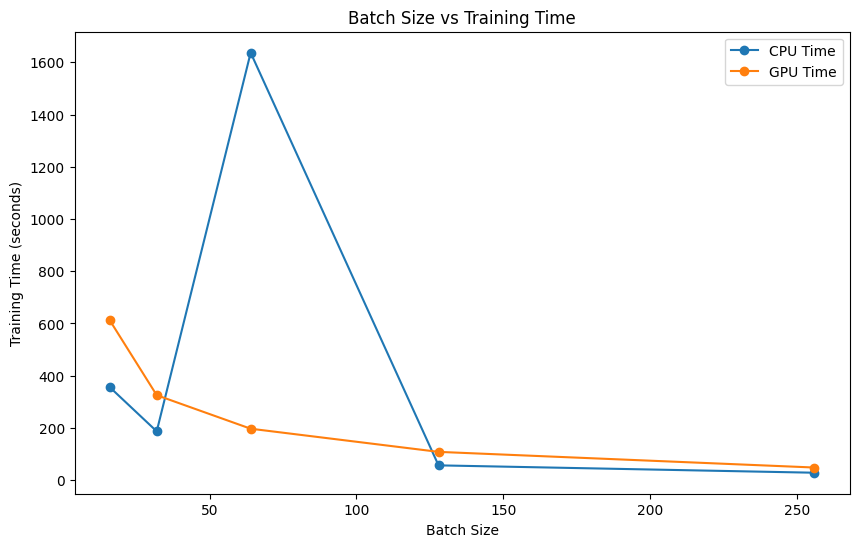

In [70]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["cpu_time"], label="CPU Time", marker='o')
plt.plot(results["batch_size"], results["gpu_time"], label="GPU Time", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()



## Batch Size vs RMSE

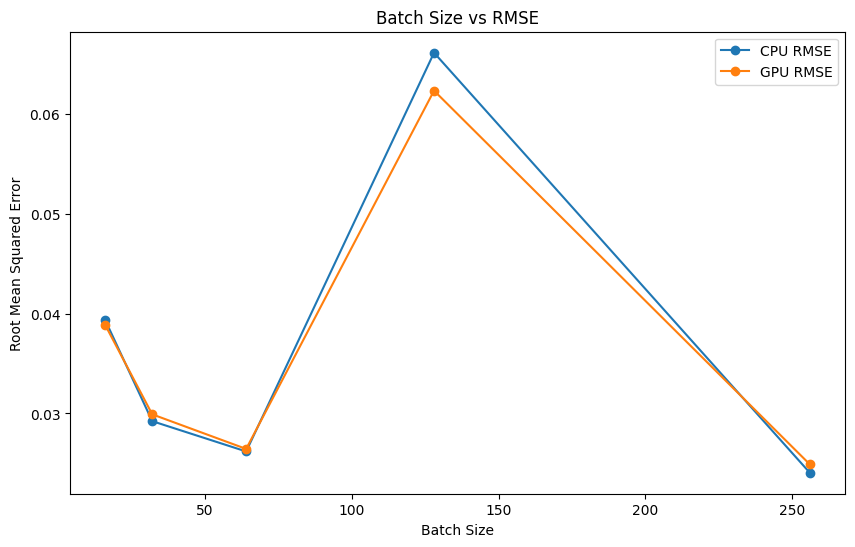

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["cpu_rmse"], label="CPU RMSE", marker='o')
plt.plot(results["batch_size"], results["gpu_rmse"], label="GPU RMSE", marker='o')
plt.title("Batch Size vs RMSE")
plt.xlabel("Batch Size")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.show()

## Reducing Complexity 

## 1) Autoencoder

Autoencoders for anomaly detection in pollution levels.

- Anomaly detection is critical for identifying abnormalities in time series data
- LSTM autoencoders leverage LSTM networks to encode time series into vector representations and reconstruct inputs
- High reconstruction error signifies anomalies not seen during training
- LSTMs help capture time dependencies well for accurate anomaly evaluation
- Autoencoder training must be optimized carefully to distinguish anomalies effectively

In [72]:
X_train.shape

(39410, 10, 8)

The model needs time to learn the important features so increase epochs and introduce early stopping.

In [73]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model


# Define the input layer
input_layer = Input(shape=(n_steps, n_features))

# Encoder part
encoded = LSTM(50, return_sequences=False)(input_layer)

# Decoder part
decoded = RepeatVector(n_steps)(encoded)
decoded = LSTM(50, return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(n_features, activation='linear'))(decoded)

# Full autoencoder model
encoder_decoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
encoder_decoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

# Summarize the full model
encoder_decoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 8)          │           408 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
with tf.device('/CPU:0'):
    autoencode_history = encoder_decoder.fit(X_train, X_train, epochs= 100, validation_split=0.1, batch_size=64,shuffle=False)

Epoch 1/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0257 - root_mean_squared_error: 0.1550 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━━━

In [75]:
X_train.shape, y_train.shape

((39410, 10, 8), (39410, 1))

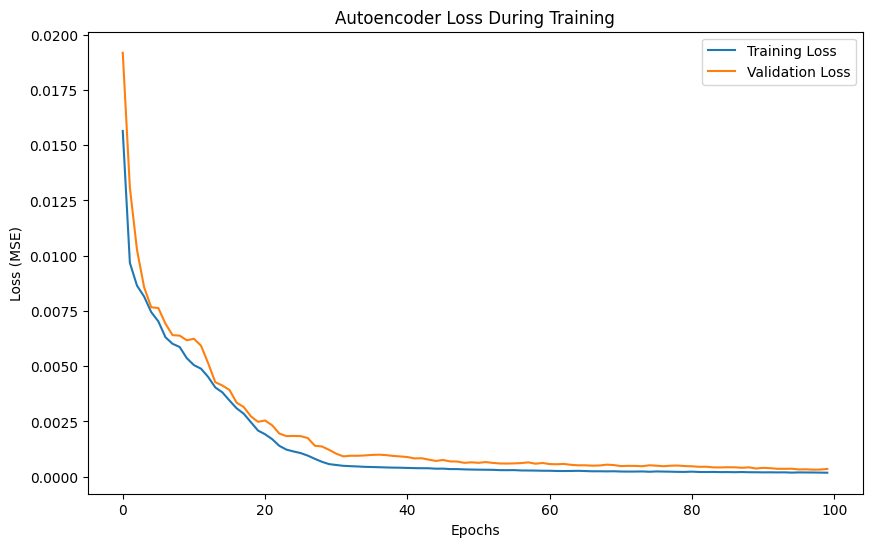

In [76]:


#Plot mle loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(autoencode_history.history['loss'], label='Training Loss')
plt.plot(autoencode_history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## Extract Encoder

In [77]:
# Extract the encoder part
encoder = Model(inputs=input_layer, outputs=encoded)

# Summarize the encoder model
encoder.summary()
# Encode the training data
encoded_X_train = encoder.predict(X_train)
encoded_X_test = encoder.predict(X_test)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        11,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,800 (46.09 KB)

 Trainable params: 11,800 (46.09 KB)

 Non-trainable params: 0 (0.00 B)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


encoded_X_train and encoded_X_test now represent a reduced dimensional representation of the original data

In [78]:
from keras.models import Sequential
from keras.layers import Dense

# Build a new model to predict y_train from encoded_X_train
predictor_model = Sequential()
predictor_model.add(Input(shape=(encoded_X_train.shape[1],)))  # Input shape of the encoded data
predictor_model.add(Dense(50))  
predictor_model.add(Dense(n_outputs, activation='linear'))  # Output layer

# Compile the model
predictor_model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

# Train the model
predictor_model.fit(encoded_X_train, y_train, epochs=20, validation_split=0.1, batch_size=32, shuffle=False )

# Predict on the test data
y_pred = predictor_model.predict(encoded_X_test)

# Evaluate the performance
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse_test:.4f}')


Epoch 1/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0042 - root_mean_squared_error: 0.0621 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 2/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 3/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 4/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 5/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 6/20
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 7/20
1109/1109 ━━━━━━━━━━━━━━━━━━━

In [79]:
encoded_X_train.shape

(39410, 50)

In [80]:
actual = y_test.flatten()
pred = y_pred.flatten()

In [81]:
results = pd.DataFrame(data={
    "test_actual": actual,
    "test_pred" : pred
})

In [82]:
results

,test_actual,test_pred
0,0.101610,0.108885
1,0.111670,0.116913
2,0.110664,0.125671
3,0.134809,0.104528
4,0.170020,0.130674
...,...,...
4365,0.008048,0.033220
4366,0.010060,0.032693
4367,0.010060,0.030440
4368,0.008048,0.022375


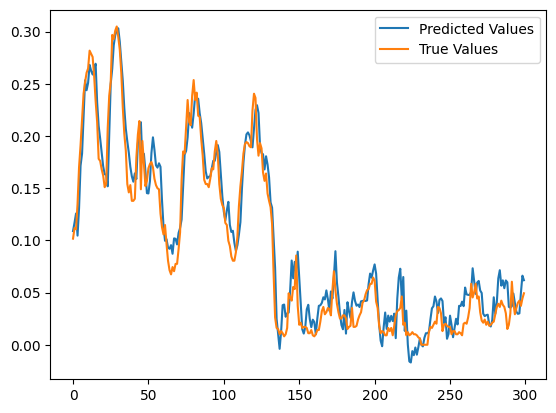

In [83]:
plt.plot(results['test_pred'][:300], label='Predicted Values')
plt.plot(results['test_actual'][:300], label='True Values')
plt.legend()
plt.show()

You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.

Let's take a look at the layers of the encoder_decoder model:


Assess how well the reconstructed dataset matches the original.

## Extract reduced feature encoder

In [84]:

rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[1].output)
bottleneck_features = rpt_vector_layer.predict(X_train)
print("Shape of Reduced Features:", bottleneck_features.shape)
print("Sample Reduced Feature Vector:", bottleneck_features[0])

   1/1232 ━━━━━━━━━━━━━━━━━━━━ 12:03 588ms/step

/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_30']. Received: the structure of inputs=*
  warnings.warn(


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Shape of Reduced Features: (39410, 50)
Sample Reduced Feature Vector: [-0.03983084 -0.09069183 -0.1611296   0.03944645  0.3141429   0.21672808
 -0.05021826 -0.01002344 -0.02687419 -0.08622546  0.00584548 -0.03825844
 -0.02351112  0.05432559 -0.0115364   0.33808953 -0.08180008  0.22658812
 -0.02195743  0.00811388  0.01018877  0.00222403 -0.04247931  0.12037889
 -0.04583118 -0.03481011  0.09260567 -0.33233634 -0.00383863  0.06362151
  0.01248165 -0.2999268   0.23612529 -0.03787682 -0.05521094  0.1852623
 -0.01108265  0.07451183  0.00553624 -0.00960527  0.00238157 -0.3019544
 -0.11005495 -0.02424611  0.3584911  -0.04491636  0.01818359  0.05593255
 -0.24964663 -0.08090387]


Train a new model MLP or LSTM using bottleneck_features
- try clustering 

In [85]:

time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
encoder_decoder.layers

[<InputLayer name=input_layer_4, built=True>,
 <LSTM name=lstm_6, built=True>,
 <RepeatVector name=repeat_vector, built=True>,
 <LSTM name=lstm_7, built=True>,
 <TimeDistributed name=time_distributed, built=True>]

In [86]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Repeat vector output shape (1, 50)
Repeat vector output sample
[-0.03983083 -0.09069186 -0.16112961  0.03944645  0.3141429   0.21672809
 -0.05021795 -0.01002348 -0.02687419 -0.08622549  0.00584544 -0.03825844
 -0.02351112  0.05432563 -0.0115364   0.3380895  -0.08180007  0.22658812
 -0.02195748  0.00811405  0.01018882  0.00222403 -0.04247926  0.12037889
 -0.04583118 -0.03481008  0.09260569 -0.3323364  -0.00383871  0.06362148
  0.01248171 -0.29992673  0.23612528 -0.03787684 -0.05521091  0.1852623
 -0.01108265  0.07451183  0.00553629 -0.00960532  0.00238157 -0.30195436
 -0.11005495 -0.02424611  0.35849106 -0.04491636  0.01818359  0.05593251
 -0.24964663 -0.08090381]


In [ ]:
from keras.utils import plot_model

plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = encoder_decoder.predict(X_train, verbose=0)
print(yhat[0,:,0])

[0.12817925 0.1310645  0.13793959 0.13653094 0.13016084 0.11606238
 0.10185628 0.09883869 0.10284048 0.11283571 0.12243301 0.12856635]


Plot the original sequence and reconstructed sequence to see how well the model is performing visually

NameError: name 'yhat' is not defined

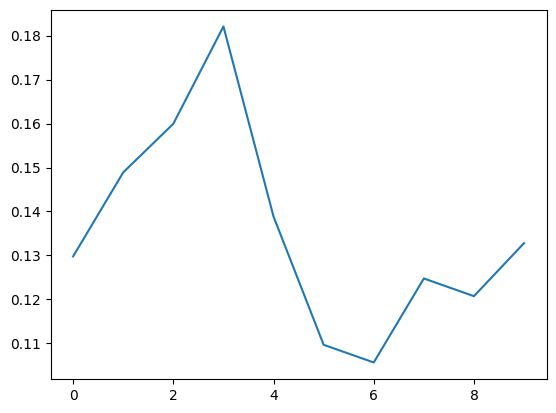

In [87]:

plt.plot(X_train[0, :, 0], label='Original')
plt.plot(yhat[0, :, 0], label='Reconstructed')
plt.legend()
plt.show()

The reconstructed sequence follows the general trend of the original sequence but does not perfectly match the exact values. For example, the reconstructed values seem to lag slightly behind the original at certain points and do not capture sharp peaks.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape bottleneck features for LSTM input
bottleneck_features_reshaped = bottleneck_features.reshape(bottleneck_features.shape[0], n_steps, -1)

# LSTM for regression
lstm = Sequential()
lstm.add(LSTM(64, activation='tanh', input_shape=(n_steps, bottleneck_features_reshaped.shape[2])))
lstm.add(Dense(1, activation='linear'))

lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])
lstm.fit(bottleneck_features_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.1)


/Users/matt/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0458 - val_loss: 8.2536e-04 - val_root_mean_squared_error: 0.0287
Epoch 2/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 7.0709e-04 - val_root_mean_squared_error: 0.0266
Epoch 3/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 7.6605e-04 - val_root_mean_squared_error: 0.0277
Epoch 4/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 8.1824e-04 - val_root_mean_squared_error: 0.0286
Epoch 5/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 7.2101e-04 - val_root_mean_squared_error: 0.0269
Epoch 6/50
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 8.8664e-04 - val_root_mean_squared_error: 0.0298
Epoch 7/50

In [ ]:
test_predictions = lstm.predict(X_test).flatten()
actual_predictions = y_test.flatten()
test_predictions.shape, actual_predictions.shape

test_results = pd.DataFrame(data={
        'Model Predictions': test_predictions,
        'Actual':actual_predictions})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,Model Predictions,Actual
0,1.007365,0.132797
1,0.906132,0.133803
2,1.027235,0.142857
3,1.039873,0.163984
4,1.035616,0.167002


In [ ]:
test_predictions = lstm.predict(X_test)

X_test_rescaled=X_test[:, -1, :].copy()

# Invert scaling for the forecast
inv_test_predictions = concatenate((test_predictions, X_test_rescaled[:, 1:]), axis=1)
inv_test_predictions = scaler.inverse_transform(inv_test_predictions)
inv_test_predictions = inv_test_predictions[:, 0]  # Extract the pollution column

y_test = y_test.reshape((len(y_test),1))
inv_actual_predictions = concatenate((y_test, X_test_rescaled[:, 1:]), axis=1)
inv_actual_predictions = scaler.inverse_transform(inv_actual_predictions)
inv_actual_predictions = inv_actual_predictions[:,0]


test_results = pd.DataFrame(data={
        'Model Predictions': inv_test_predictions,
        'Actual':inv_actual_predictions})
  

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actual_predictions, inv_test_predictions))
print('Test RMSE: %.3f' % rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test RMSE: 812.895


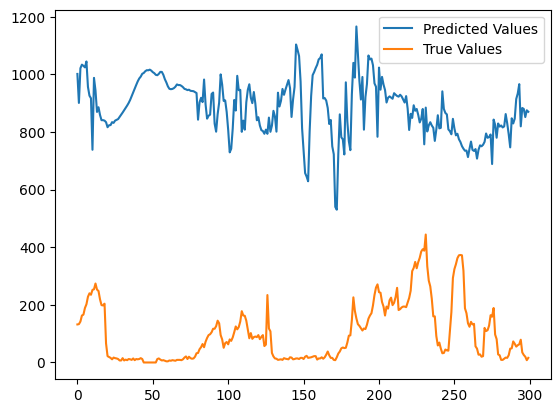

In [ ]:
plt.plot(test_results['Model Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

In [ ]:

# Calculate reconstruction errors for each sample
reconstruction_errors = np.mean(np.square(X_train - yhat), axis=(1, 2))

# Average reconstruction error across all samples
mean_reconstruction_error = np.mean(reconstruction_errors)
print("Mean Reconstruction Error:", mean_reconstruction_error)


plt.hist(reconstruction_errors, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = encoder_decoder.predict(X_train, verbose=0)
print(yhat[0,:,0])

[0.13243482 0.13483289 0.13909769 0.14202374 0.14107472 0.1346105
 0.12371591 0.11455051 0.11061565 0.10822196 0.10639656 0.10655204]


## Create an Encoder

In [88]:
encoder_input = encoder_decoder.input
encoder_output = encoder_decoder.layers[1].output  #The output of the encoder LSTM layer
encoder_model = Model(inputs=encoder_input, outputs=encoder_output)


In [89]:
#Get Bottleneck Features (Compressed Representation)
bottleneck_features = encoder_model.predict(X_train)
print('Bottleneck Features Shape:', bottleneck_features.shape)
print('Bottleneck Feature Sample:', bottleneck_features[0])

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Bottleneck Features Shape: (39410, 50)
Bottleneck Feature Sample: [-0.03983084 -0.09069183 -0.1611296   0.03944645  0.3141429   0.21672808
 -0.05021826 -0.01002344 -0.02687419 -0.08622546  0.00584548 -0.03825844
 -0.02351112  0.05432559 -0.0115364   0.33808953 -0.08180008  0.22658812
 -0.02195743  0.00811388  0.01018877  0.00222403 -0.04247931  0.12037889
 -0.04583118 -0.03481011  0.09260567 -0.33233634 -0.00383863  0.06362151
  0.01248165 -0.2999268   0.23612529 -0.03787682 -0.05521094  0.1852623
 -0.01108265  0.07451183  0.00553624 -0.00960527  0.00238157 -0.3019544
 -0.11005495 -0.02424611  0.3584911  -0.04491636  0.01818359  0.05593255
 -0.24964663 -0.08090387]


In [90]:
# Plot Model Diagram
plot_model(encoder_decoder, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')


NameError: name 'plot_model' is not defined

In [ ]:
# Demonstrate Reconstruction
yhat = encoder_decoder.predict(X_train, verbose=0)


In [ ]:
# Plot Original vs Reconstructed Data
plt.plot(X_train[0, :, 0], label='Original')
plt.plot(yhat[0, :, 0], label='Reconstructed')
plt.legend()
plt.title('Original vs Reconstructed Sequence')
plt.show()

# Calculate Reconstruction Errors
reconstruction_errors = np.mean(np.square(X_train - yhat), axis=(1, 2))
print("Reconstruction Errors:", reconstruction_errors)

## PredictionLSTM Autoencoder 

## Modify the decoder to predict future time steps instead of reconstructing the input.

## 2) Lag-1 Features 

In [91]:
window_size = 2
N= len(train_data)
X_train_lagged, y_train_lagged = generate_sequence(train_data,N, window_size)
print(X_train_lagged.shape, y_train_lagged.shape)

M=len(test_data)
X_test_lagged, y_test_lagged = generate_sequence(test_data,M,window_size)
print(X_test_lagged.shape,y_test_lagged.shape)

(39418, 2, 8) (39418, 1)
(4378, 2, 8) (4378, 1)


In [95]:
n_steps = X_train_lagged.shape[1]
n_features = X_train_lagged.shape[2]
n_outputs = y_train_lagged.shape[1]

In [96]:
n_steps

2

In [97]:
tf.random.set_seed(7)
LAG_LSTM = Sequential()
LAG_LSTM.add(Input(shape =(n_steps, n_features)))
LAG_LSTM.add(LSTM(32,return_sequences=True))
LAG_LSTM.add(Dropout(0.1)) #Prevent overfitting
LAG_LSTM.add(LSTM(16, return_sequences=False))
LAG_LSTM.add(Dense(n_outputs, activation ='linear')) 

LAG_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

# Save the initial weights of the model right after it is defined and compiled
initial_lag_weights = LAG_LSTM.get_weights()

LAG_LSTM.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 2, 32)          │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
batch_sizes = [16, 32, 64, 128, 256]  # Different batch sizes to test
results = {"batch_size": [], "lag_rmse":[], "lag_time": [],"stck_rmse":[], "stck_time": []}

In [103]:
for batch_size in batch_sizes:
    # CPU
    with tf.device('/CPU:0'):
        STCK_LSTM.set_weights(initial_weights)
        start_time = time.time()
        STCK_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=batch_size, shuffle=False)
        stck_time = time.time() - start_time
        stck_scores = STCK_LSTM.evaluate(X_test, y_test)

    # GPU
    with tf.device('/CPU:0'):
        LAG_LSTM.set_weights(initial_lag_weights)
        start_time = time.time()
        LAG_LSTM.fit(X_train_lagged, y_train_lagged, epochs=20, validation_split=0.1, batch_size=batch_size, shuffle=False)        
        lag_time = time.time() - start_time
        lag_scores = LAG_LSTM.evaluate(X_test, y_test)


    # Record results
    results["batch_size"].append(batch_size)
    results["lag_rmse"].append(lag_scores[1])  # Root Mean Squared Error for LAG_LSTM
    results["lag_time"].append(lag_time)
    results["stck_rmse"].append(stck_scores[1])  # Root Mean Squared Error for STCK_LSTM
    results["stck_time"].append(stck_time)

Epoch 1/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0041 - root_mean_squared_error: 0.0621 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 2/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 3/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 4/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 5/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 9.9285e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/20
2217/2217 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 9.9718e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 7/20
2217/2217 ━━━━━

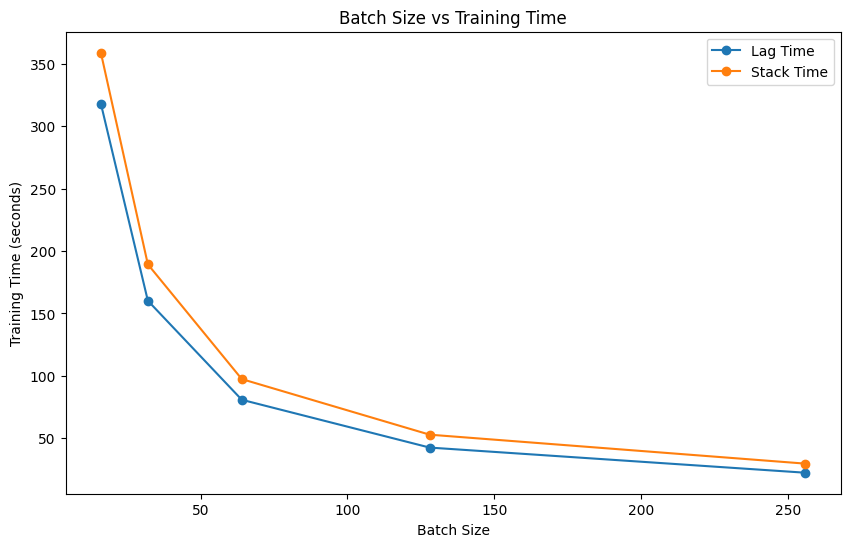

In [100]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["lag_time"], label="Lag Time", marker='o')
plt.plot(results["batch_size"], results["stck_time"], label="Stack Time", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()

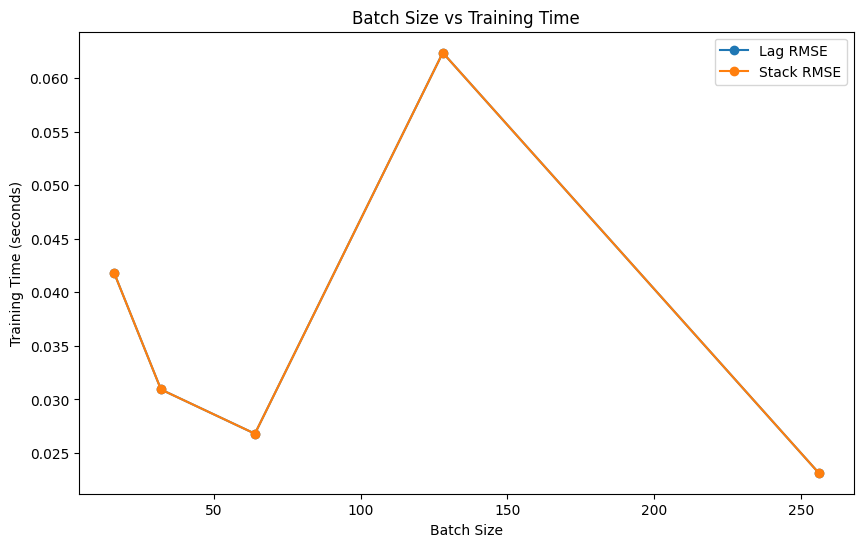

In [102]:

plt.figure(figsize=(10, 6))
plt.plot(results["batch_size"], results["lag_rmse"], label="Lag RMSE", marker='o')
plt.plot(results["batch_size"], results["stck_rmse"], label="Stack RMSE", marker='o')
plt.title("Batch Size vs Training Time")
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.show()

# PYSPARKING AN LSTM